In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
import dask.dataframe as dd
from asyncio import CancelledError
from dask.delayed import delayed
from dask.distributed import Client
from cycler import cycler
from IPython.display import clear_output
import matplotlib.gridspec as gridspec
import pickle
import warnings
import geopandas as gpd
from keplergl import KeplerGl
from shapely.geometry import Point, Polygon 
from IPython.display import IFrame

In [2]:
default_colors = ['#00c6ff', '#0078ff', '#dd2a7b']
mpl.rcParams['axes.prop_cycle'] = cycler('color', default_colors)
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['legend.title_fontsize'] = 18

# pd.set_option('display.max_colwidth', None)

## 1 Executive Summary

As years passed by, technology is becoming more and more advanced. Today, social media have become a staple in everyday lives of people and becoming one of the main methods of social connection and interaction around the world [1]. Among the social media platforms, Facebook is popular among people. In 2020, the expected number of Facebook users would reach around 1.69 billion [3]. With the huge user base of Facebook, it serves as a mode of communication and way of obtaining of information not only about the friends and family but also the local and national issues. Facebook also serve as an important channel for businesses in terms of marketing and advertising.

With the facts mentioned above, the group answered the question **"What is the distribution of the population density of Facebook users across European countries?"**. In answering this question, the group had analyzed the high population density dataset amounting to a total of over 8.12 Gb. To handle a big amount of data surpassing the capability of the local machine/client's memory, the group had used distributed dask clustering. Here are the steps we took to answer this question:

1. Extracted data from https://registry.opendata.aws/dataforgood-fb-hrsl/. The group had chosen 24 European countries.
2. Processed data such as feature engineering and merging of columns
3. Performed exploratory data analysis

## 2 Introduction

Social media focused on building social networks and relations among people with shared interests [1]. Among the social media platforms, Facebook is one of the most popular. In the first quarter of 2015, there are around 1.44 billion active users of Facebook [2].  Statistics had also showed that in 2020, the expected number of Facebook users would reach 1.69 billion [3]. Nowadays, people tend to reach some of the most significant news through Facebook and it also served as as tool for organization of events [2]. Facebook lead to a wider scope of applications with increasing global impact on society and government [1]. The team wants to analyze the distribution of the population density of Facebook users across European countries and create recommendations.

## 3 Data

### 3.1 Data Description

### 3.2 Data Extraction

In [3]:
client = Client('172.31.27.218:8786')

/opt/conda/lib/python3.8/site-packages/distributed/client.py:1129: VersionMismatchWarning: Mismatched versions found

+---------+---------------+---------------+---------------+
| Package | client        | scheduler     | workers       |
+---------+---------------+---------------+---------------+
| python  | 3.8.2.final.0 | 3.8.2.final.0 | 3.8.5.final.0 |
+---------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [4]:
client

Client Scheduler: tcp://172.31.27.218:8786 Dashboard: http://172.31.27.218:8787/status,Cluster Workers: 3 Cores: 6 Memory: 25.04 GB


In [5]:
def get_path(country):
    """Return country CSV path"""
    return dict(total_pop=('s3://dataforgood-fb-data/csv/month=2019-06'
                           f'/country={country}/type=total_population'
                           f'/{country}_total_population.csv.gz'),
                child=('s3://dataforgood-fb-data/csv/month=2019-06'
                       f'/country={country}/type=children_under_five'
                       f'/{country}_children_under_five.csv.gz'),
                elder=('s3://dataforgood-fb-data/csv/month=2019-06'
                       f'/country={country}/type=elderly_60_plus'
                       f'/{country}_elderly_60_plus.csv.gz'),
                men=('s3://dataforgood-fb-data/csv/month=2019-06'
                     f'/country={country}/type=men'
                     f'/{country}_men.csv.gz'),
                women=('s3://dataforgood-fb-data/csv/month=2019-06'
                       f'/country={country}/type=women'
                       f'/{country}_women.csv.gz'),
                reprod=('s3://dataforgood-fb-data/csv/month=2019-06'
                        f'/country={country}'
                        '/type=women_of_reproductive_age_15_49'
                        f'/{country}_women_of_'
                        'reproductive_age_15_49.csv.gz'),
                youth=('s3://dataforgood-fb-data/csv/month=2019-06'
                       f'/country={country}/type=youth_15_24'
                       f'/{country}_youth_15_24.csv.gz')
                )

In [6]:
countries = ['GBR',
             'FRA',
             'ITA',
             'ESP',
             'PRT',
             'CHE',
             'GRC',
             'DEU',
             'NLD',
             'POL',
             'BEL',
             'AUT',
             'ISL',
             'HRV',
             'CZE',
             'ROU',
             'UKR',
             'HUN',
             'ALB',
             'SVK',
             'MNE',
             'MDA',
             'SRB',
             'BLR']

In [7]:
df_countries_total_pop = dict()
df_countries_men = dict()
df_countries_women = dict()

#### 3.2.1 Total Population

In [12]:
for country in countries:
    print('Extracting data from {}'.format(country))
    dfs_total_pop = [delayed(pd.read_csv)(get_path(country)['total_pop'],
                                          encoding='utf-8', sep='\t',
                                          compression='gzip')]
    print('Converting to DataFrame {}'.format(country))

    try:
        df_total_pop = dd.from_delayed(dfs_total_pop)
    except CancelledError:
        df_total_pop = dd.from_delayed(dfs_total_pop)

    print('Repartition {}'.format(country))
    df_total_pop = df_total_pop.repartition(npartitions=100)
    df_countries_total_pop[country] = df_total_pop

    del dfs_total_pop
    del df_total_pop

clear_output()
print('Done')

#### 3.2.2 Women

In [12]:
for country in countries:
    print('Extracting data from {}'.format(country))
    dfs_women = [delayed(pd.read_csv)(get_path(country)['women'],
                                      encoding='utf-8', sep='\t',
                                      compression='gzip')]
    print('Converting to DataFrame {}'.format(country))

    try:
        df_women = dd.from_delayed(dfs_women)
    except CancelledError:
        df_women = dd.from_delayed(dfs_women)

    print('Repartition {}'.format(country))
    df_women = df_women.repartition(npartitions=100)
    df_countries_women[country] = df_women

    del dfs_women
    del df_women

clear_output()
print('Done')

Done


#### 3.2.3 Men

In [13]:
for country in countries:
    print('Extracting data from {}'.format(country))
    dfs_men = [delayed(pd.read_csv)(get_path(country)['men'],
                                    encoding='utf-8', sep='\t',
                                    compression='gzip')]
    print('Converting to DataFrame {}'.format(country))

    try:
        df_men = dd.from_delayed(dfs_men)
    except CancelledError:
        df_men = dd.from_delayed(dfs_men)

    print('Repartition {}'.format(country))
    df_men = df_men.repartition(npartitions=100)
    df_countries_men[country] = df_men

    del dfs_men
    del df_men

clear_output()
print('Done')

Done


## 4 Data Preprocessing


Merge all the datasets per category to compare different countries. We added a new column country and people count to determine the total number of people per 30 sqm and identify which country the row belonged.

In [9]:
def add_features(df, country):
    """Return dataframe with required column columns"""
    df = df.copy()
    # Group data by 2 degrees
    step = 0.2
    to_bin = lambda x: np.floor(x / step) * step
    df["latbin"] = df.latitude.map(to_bin)
    df["lonbin"] = df.longitude.map(to_bin)
    df = df.groupby(['latbin', 'lonbin'])['population'].sum().to_frame()
    df['country'] = country
   
    return df

### 4.1 Total Population

In [14]:
df_total_pop = dd.concat([add_features(ddf, country)
                          for country, ddf in df_countries_total_pop.items()],
                         axis=0)

In [15]:
df_total_pop.count().compute()

population    15569
country       15569
dtype: int64

### 4.2 Women

In [16]:
df_women = dd.concat([add_features(ddf, country)
                      for country, ddf in df_countries_women.items()],
                     axis=0)

In [17]:
df_women.count().compute()

population    15569
country       15569
dtype: int64

### 4.3 Men

In [18]:
df_men = dd.concat([add_features(ddf, country)
                    for country, ddf in df_countries_men.items()],
                   axis=0)

In [19]:
df_men.count().compute()

population    15569
country       15569
dtype: int64

# 5 Exploratory Data Analysis

### 5.1 Men, Women and Overall Population across European Countries

In [61]:
total_pop_all = df_total_pop.groupby(['country']).population.sum().compute()
total_pop_all.sort_values(inplace=True)
total_pop_women = df_women.groupby(['country']).population.sum().compute()
total_pop_women.sort_values(inplace=True)
total_pop_men = df_men.groupby(['country']).population.sum().compute()
total_pop_men.sort_values(inplace=True)

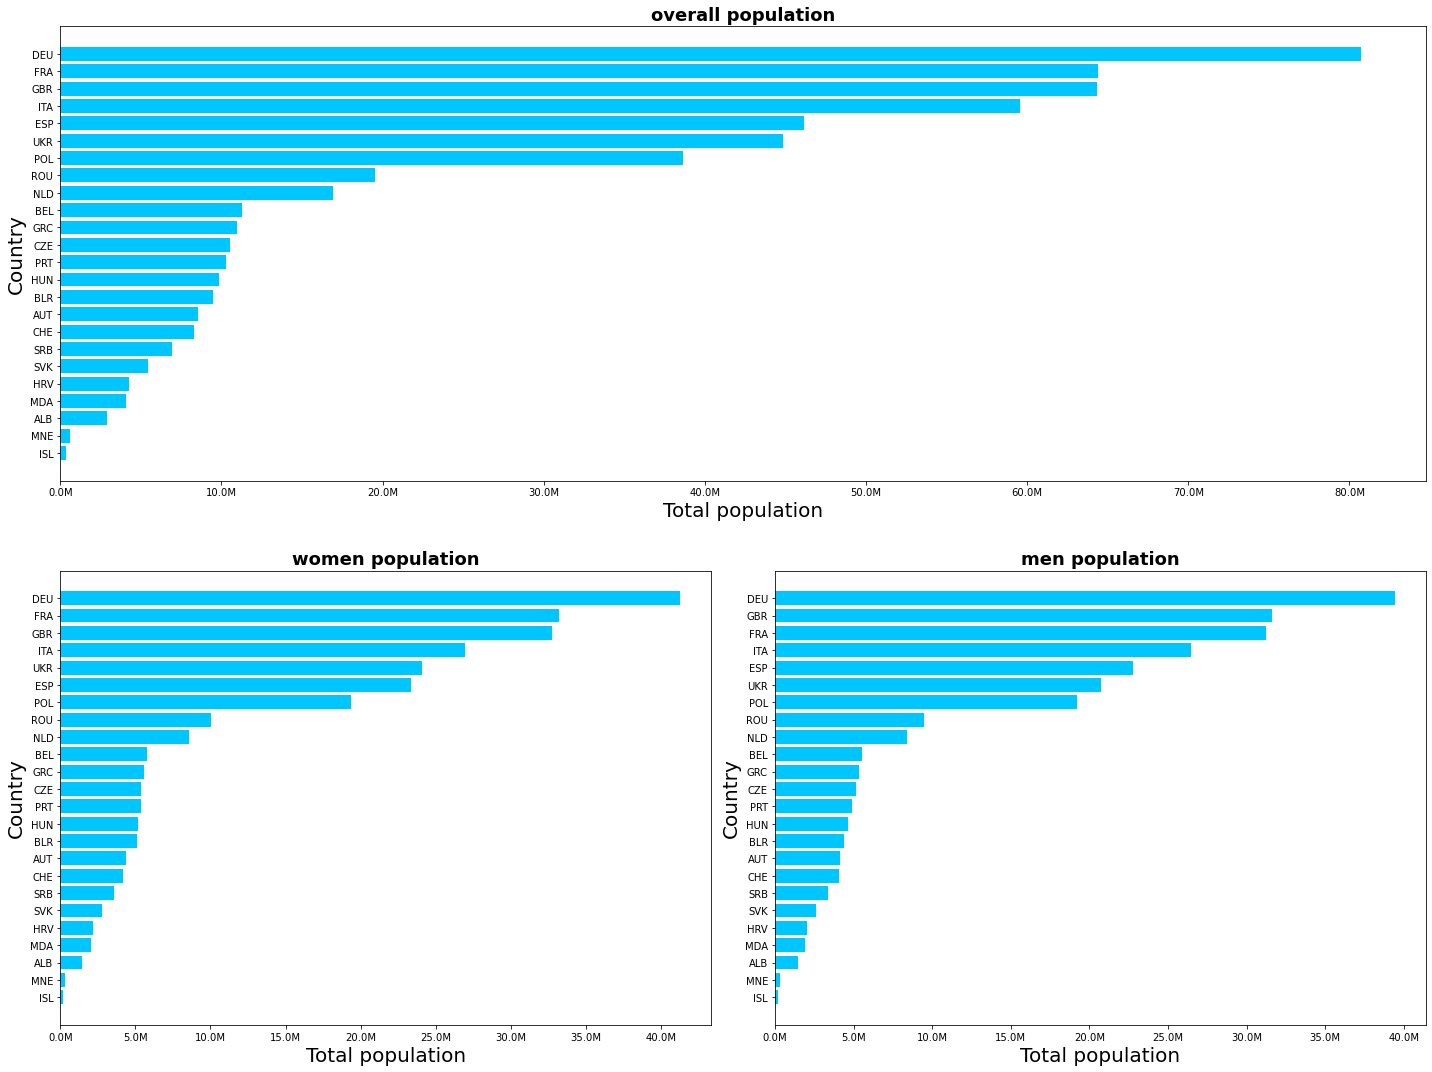

In [60]:
fig1 = plt.figure(constrained_layout=False, figsize=(20, 15))
spec1 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig1)

ax0 = fig1.add_subplot(spec1[0, :])
ax1 = fig1.add_subplot(spec1[1:, 0])
ax2 = fig1.add_subplot(spec1[1:, 1:])

y_total_pop_all = total_pop_all.index
x_total_pop_all = total_pop_all.values

y_women = total_pop_women.index
x_women = total_pop_women.values

y_men = total_pop_men.index
x_men = total_pop_men.values

# Plot data
ax0.barh(y_total_pop_all, x_total_pop_all)
ax0.set_title('overall population')
ax0.set_ylabel('Country')
ax0.set_xlabel('Total population')

ax1.barh(y_women, x_women)
ax1.set_title('women population')
ax1.set_ylabel('Country')
ax1.set_xlabel('Total population')

ax2.barh(y_men, x_men)
ax2.set_title('men population')
ax2.set_ylabel('Country')
ax2.set_xlabel('Total population')

# Change ticks
xlabels = [f'{x:.1f}M' for x in ax0.get_xticks()/1e6]
ax0.set_xticklabels(xlabels)

xlabels = [f'{x:.1f}M' for x in ax1.get_xticks()/1e6]
ax1.set_xticklabels(xlabels)

xlabels = [f'{x:.1f}M' for x in ax2.get_xticks()/1e6]
ax2.set_xticklabels(xlabels)

plt.tight_layout(h_pad=3)
plt.show()
warnings.filterwarnings('ignore')

As observed on the figure above (Refer to Fig. ##), Germany (`DEU`)has the highest overall population size across the selected European countries followed by France (`FRA`) and United Kingdom (`GBR`). Germany is considered to be most populated country across the European Union and possess one of the largest economies in the world [9]. In addition, Germany also has the highest men and women population size across the European countries. 

## 6 Geospatial Analysis

In [52]:
# Configuration of DEU maps
config_deu = {'version': 'v1',
              'config': {'visState':
                         {'filters': [],
                          'layers': [
                          {'id': 'jlfb1euw',
                           'type': 'heatmap',
                           'config': {
                               'dataId': 'population',
                               'label': 'population',
                               'color': [255, 153, 31],
                               'columns': {'lat': 'latbin', 'lng': 'lonbin'},
                               'isVisible': True,
                               'visConfig': {
                                   'opacity': 0.8,
                                   'colorRange': {
                                       'name': 'Uber Viz Diverging 1.5',
                                       'type': 'diverging',
                                       'category': 'Uber',
                                       'colors': ['#00939C',
                                                  '#5DBABF',
                                                  '#BAE1E2',
                                                  '#F8C0AA',
                                                  '#DD7755',
                                                  '#C22E00']},
                                   'radius': 84},
                               'hidden': False,
                               'textLabel': [{'field': None,
                                              'color': [255, 255, 255],
                                              'size': 18,
                                              'offset': [0, 0],
                                              'anchor': 'start',
                                              'alignment': 'center'}]},
                           'visualChannels': {
                               'weightField': {
                                   'name': 'population', 'type': 'real'},
                               'weightScale': 'linear'}}],
                          'interactionConfig': {
                          'tooltip': {
                              'fieldsToShow': {
                                  'population': [{'name': 'latbin',
                                                  'format': None},
                                                 {'name': 'lonbin',
                                                  'format': None},
                                                 {'name': 'population',
                                                  'format': None}]},
                              'compareMode': False,
                              'compareType': 'absolute',
                              'enabled': True},
                             'brush': {'size': 0.5, 'enabled': False},
                             'geocoder': {'enabled': False},
                             'coordinate': {'enabled': False}},
                             'layerBlending': 'normal',
                             'splitMaps': [],
                             'animationConfig': {
                                 'currentTime': None, 'speed': 1}},
                         'mapState': {'bearing': 0,
                                      'dragRotate': False,
                                      'latitude': 51.1,
                                      'longitude': 10.4,
                                      'pitch': 0,
                                      'zoom': 5,
                                      'isSplit': False},
                         'mapStyle': {
                             'styleType': 'light',
                             'topLayerGroups': {},
                             'visibleLayerGroups': {
                                          'label': True,
                                          'road': True,
                                          'border': False,
                                          'building': True,
                                          'water': True,
                                          'land': True,
                                          '3d building': False},
                             'threeDBuildingColor': [218.82023004728686,
                                                     223.47597962276103,
                                                     223.47597962276103],
                             'mapStyles': {}}}}

# Configuration of maps
config_gbr = {'version': 'v1',
              'config': {'visState':
                         {'filters': [],
                          'layers': [
                          {'id': 'jlfb1euw',
                           'type': 'heatmap',
                           'config': {
                               'dataId': 'population',
                               'label': 'population',
                               'color': [255, 153, 31],
                               'columns': {'lat': 'latbin', 'lng': 'lonbin'},
                               'isVisible': True,
                               'visConfig': {
                                   'opacity': 0.8,
                                   'colorRange': {
                                       'name': 'Uber Viz Diverging 1.5',
                                       'type': 'diverging',
                                       'category': 'Uber',
                                       'colors': ['#00939C',
                                                  '#5DBABF',
                                                  '#BAE1E2',
                                                  '#F8C0AA',
                                                  '#DD7755',
                                                  '#C22E00']},
                                   'radius': 84},
                               'hidden': False,
                               'textLabel': [{'field': None,
                                              'color': [255, 255, 255],
                                              'size': 18,
                                              'offset': [0, 0],
                                              'anchor': 'start',
                                              'alignment': 'center'}]},
                           'visualChannels': {
                               'weightField': {
                                   'name': 'population', 'type': 'real'},
                               'weightScale': 'linear'}}],
                          'interactionConfig': {
                          'tooltip': {
                              'fieldsToShow': {
                                  'population': [{'name': 'latbin',
                                                  'format': None},
                                                 {'name': 'lonbin',
                                                  'format': None},
                                                 {'name': 'population',
                                                  'format': None}]},
                              'compareMode': False,
                              'compareType': 'absolute',
                              'enabled': True},
                             'brush': {'size': 0.5, 'enabled': False},
                             'geocoder': {'enabled': False},
                             'coordinate': {'enabled': False}},
                             'layerBlending': 'normal',
                             'splitMaps': [],
                             'animationConfig': {
                                 'currentTime': None, 'speed': 1}},
                         'mapState': {'bearing': 0,
                                      'dragRotate': False,
                                      'latitude': 54.60604517170306,
                                      'longitude': -3.819726562499494,
                                      'pitch': 0,
                                      'zoom': 5,
                                      'isSplit': False},
                         'mapStyle': {
                             'styleType': 'light',
                             'topLayerGroups': {},
                             'visibleLayerGroups': {
                                          'label': True,
                                          'road': True,
                                          'border': False,
                                          'building': True,
                                          'water': True,
                                          'land': True,
                                          '3d building': False},
                             'threeDBuildingColor': [218.82023004728686,
                                                     223.47597962276103,
                                                     223.47597962276103],
                             'mapStyles': {}}}}

In [53]:
map_deu = KeplerGl(height=600, width=800, config=config_deu)
ddf_deu = add_features(df_countries_total_pop['DEU'],
                       'DEU').population.reset_index().persist()
gdf_deu = gpd.GeoDataFrame(ddf_deu.compute(),
                           geometry=gpd.points_from_xy(
                               ddf_deu.lonbin.compute(),
                               ddf_deu.latbin.compute()))
map_deu.add_data(data=gdf_deu, name="population")
map_deu.save_to_html(file_name='deu_total_pop.html')
map_deu.close()

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to deu_total_pop.html!


In [54]:
map_deu = KeplerGl(height=600, width=800, config=config_deu)
ddf_deu = add_features(df_countries_women['DEU'],
                       'DEU').population.reset_index().persist()
gdf_deu = gpd.GeoDataFrame(ddf_deu.compute(),
                           geometry=gpd.points_from_xy(
                               ddf_deu.lonbin.compute(),
                               ddf_deu.latbin.compute()))
map_deu.add_data(data=gdf_deu, name="population")
map_deu.save_to_html(file_name='deu_women.html')
map_deu.close()

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to deu_women.html!


In [56]:
map_deu = KeplerGl(height=600, width=800, config=config_deu)
ddf_deu = add_features(df_countries_men['DEU'],
                       'DEU').population.reset_index().persist()
gdf_deu = gpd.GeoDataFrame(ddf_deu.compute(),
                           geometry=gpd.points_from_xy(
                               ddf_deu.lonbin.compute(),
                               ddf_deu.latbin.compute()))
map_deu.add_data(data=gdf_deu, name="population")
map_deu.save_to_html(file_name='deu_men.html')
map_deu.close()

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to deu_men.html!


### Overall Population in Germany (DEU)

In [57]:
IFrame(src='deu_total_pop.html', width=950, height=600)

As shown in the map above, Berlin has the highest abundance of Facebook users across Germany. The result is expected given that Berlin is the capital of Germany. There is also an abundance of population in the west side of Germany which include the city of Bonn. Bonn is the former capital of Germany. In addition, Munich, Frankfurt and Hamburg also showed an abundance of Facebook users. Frankfurt is considered to be the metropolis and the largest financial centre in the continental Europe [10]. Munich is the third largest city in Germany where its economy is based on the high tech, automobiles and service sector [11]. Lastly, Hamburg is the second largest city in Germany and considered to have the largest port and commercial centre [12]. 

The German policy mainly focus on the peace and security. Given the abundance of Facebook users in the big cities of Germany, Facebook could serve as a channel for the distribution of information or news in regards to the current security of the area. 

### Women Population in Germay (DEU)

In [58]:
IFrame(src='deu_women.html', width=950, height=600)

Given that the biggest cities of Germany namely: Frankfurt, Munich, Hamburg and Berlin have the highest abundance of overall population of Facebook users, we could expect the distribution of female Facebook users are also the same case (shown in the map above).  The abudance of Female Facebook users on the specific cities could aid some businesses for their targeted marketing in terms of their products. Advertising of products through Facebook could also be done.

### Men Population in Germay (DEU)

In [59]:
IFrame(src='deu_men.html', width=950, height=600)

In Germany, the population of women is significantly higher compared to men [13]. This fact is proved based on the differences of the resuting graph between the men and women population. It is evident on the west side of Germany that there is more abundance of women compared to men. One of the pressing challenges faced by the German population is the ageing structure with the slow birth rates [13].

# References

[1] Salem, Fadi & Mourtada, Rachi. (2011). _Facebook Usage: Factors and Analysis_. Arab Social Media Report.

[2]  Boukouvidis, T. (2015). _Four Reasons Facebook Is So Popular_. Retrieved 29 November 2020, from https://www.theodysseyonline.com/four-reasons-facebook-so-popular.

[3] Clement, J. (2019). _Facebook: number of users worldwide_. Retrieved 29 November 2020, from https://www.statista.com/statistics/490424/number-of-worldwide-facebook-users/#:~:text=This%20statistic%20shows%20the%20number,from%201.34%20million%20in%202014.

[4] _"Latitude" vs. "Longitude"_. Dictionary.com. (2020). Retrieved 29 November 2020, from https://www.dictionary.com/e/latitude-vs-longitude/.

[5]

[6]

[7]

[8]

[9] _Overview of Germany_. Retrieved 30 November 2020, from https://www.usnews.com/news/best-countries/germany.

[10] _Frankfurt_. En.wikipedia.org. Retrieved 30 November 2020, from https://en.wikipedia.org/wiki/Frankfurt.

[11] _Munich_. En.wikipedia.org. Retrieved 30 November 2020, from https://en.wikipedia.org/wiki/Munich.

[12] Thomsen, H. _Hamburg | History, Population, Points of Interest, & Facts_. Encyclopedia Britannica. Retrieved 30 November 2020, from https://www.britannica.com/place/Hamburg-Germany.

[13] Koptyug, E. (2020). Population by gender Germany 1990-2019. Retrieved 30 November 2020, from https://www.statista.com/statistics/454338/population-by-gender-germany/.

# Appendices

### Appendix A. Running of Instances

<img src = "instances.PNG">

### Appendix B. Client

<img src = "client.PNG">